# Image Classification


In this project I will build an image classification model using convolution neural networks (CNNs) using
smaller version of the cats-and-dogs dataset form the following URL
URL: 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

I will follow the below order while building the image classification model.

1. Download the dataset
2. Explore the data
3. Preprocess and prepare the data for modeling
4. Develop a model with transfer learning using MobileNet V2 as the base model
5. Fine tune the model by unfreezing some top layers of the base model and retraining.

## Setup

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations
import os  # For file and directory operations
import tensorflow as tf  # For deep learning framework


## Data preprocessing
### Data download

The below code will now retrieve the dataset from the given web address, unzips it, and establish the locations for the training and validation folders. Next, it will outline settings for the group size and picture dimensions, and constructs a dataset from the training folder based on these specifications.

In [3]:
# Define the URL where the dataset is hosted
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Download and extract the dataset, saving it to a specified path
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# Define the path to the extracted dataset
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Define the paths to the training and validation directories
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Define batch size and image dimensions
BATCH_SIZE = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)

# Create a dataset from the training directory, with specified parameters
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [5]:
# Create a dataset for validation images from the validation directory.
# - 'shuffle=True' means the images will be mixed up for better learning.
# - 'batch_size=BATCH_SIZE' means we'll look at the images in groups of 32.
# - 'image_size=IMG_SIZE' sets the size of the images to 160x160 pixels.
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


### Show some images

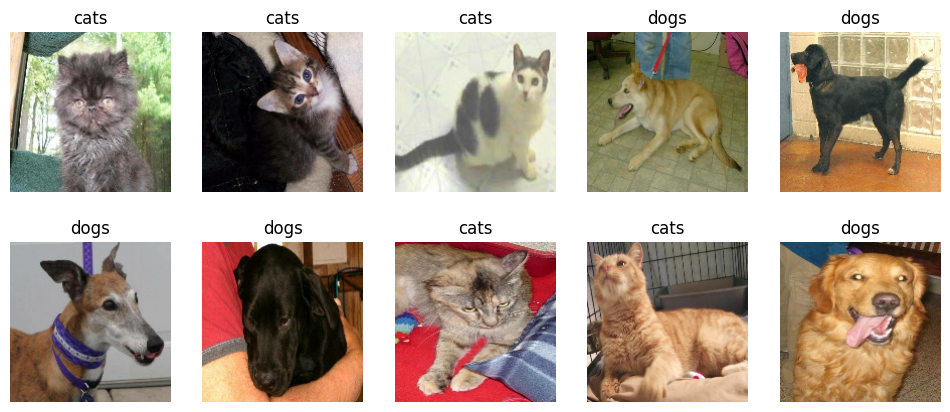

In [6]:
# Get the class names (in this case, 'cats' and 'dogs') from the training dataset.
class_names = train_dataset.class_names

# Create a figure to display images.
# Loop through the first batch of images and labels from the training dataset.
# Display 10 of them in a 2x5 grid with their corresponding class names.
plt.figure(figsize=(12, 5))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    # Show the image as a picture and add its class name as a title.
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The code displays a figure with 10 images of cats and dogs in a 2x5 grid. Each image is accompanied by its corresponding class name ('cat' or 'dog'). This gives a visual preview of the training data, allowing us to see examples of the two classes the model will learn to distinguish.

### Split the data
As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [7]:
# Calculate the total number of batches in the validation dataset.
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Create a test dataset with 1/5 of the validation batches.
test_dataset = validation_dataset.take(val_batches // 5)

# Remove the test samples from the validation dataset.
validation_dataset = validation_dataset.skip(val_batches // 5)

# Print the number of batches in the modified validation and test datasets.
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking.

To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
# Define a special value 'AUTOTUNE' which allows TensorFlow to automatically tune the data loading process for optimal performance.

# Prefetching improves training speed by allowing the GPU to load data while it's processing the previous batch.
# It loads data in the background, reducing idle time for the GPU.

# Apply prefetching to the training dataset to make it load data efficiently.
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Apply prefetching to the validation dataset.
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Apply prefetching to the test dataset.
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## A basic Keras model
### VGG-1 model


In [10]:
# Import necessary modules from Keras for building and training the model.
from keras.api._v2.keras import metrics
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers

# Define a model with 1 VGG block.
model = Sequential([
  # Rescale pixel values to be in the range [0, 1].
  layers.Rescaling(1./255, input_shape=(160, 160, 3)),
  # Apply a 2D convolutional layer with 32 filters, using 'relu' activation function.
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  # Apply max pooling to reduce the spatial dimensions of the feature map.
  layers.MaxPooling2D((2, 2)),
  # Flatten the feature map for input to fully connected layers.
  layers.Flatten(),
  # Add a fully connected layer with 128 units and 'relu' activation function.
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  # Add an output layer with 1 unit and 'sigmoid' activation function for binary classification.
  layers.Dense(1, activation='sigmoid')
])

# Compile the model with stochastic gradient descent (SGD) optimizer.
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

We can see that the above model summary provides an overview of a neural network created using the Keras framework. It's a sequential model, meaning layers are stacked sequentially. The layers and their properties are detailed, including their output shapes and the number of trainable parameters. The "rescaling" layer preprocesses input pixel values, the "conv2d" layer has 32 filters, "max_pooling2d" reduces spatial dimensions, and "flatten" reshapes the data. The "dense" layer is a fully connected hidden layer with 128 units, and "dense_1" is the output layer for binary classification. The model contains a total of 26,215,553 parameters, with all being trainable, except for the non-trainable "rescaling" and "max_pooling2d" layers. This architecture allows the model to capture complex data patterns.

In [11]:
# Train the model using the specified number of epochs.
# 'epochs=12' means the model will be trained for 12 passes through the entire dataset.

# The 'model.fit' function trains the model on the training dataset and validates on the validation dataset.

epochs=12  # Define the number of training epochs.
history = model.fit(
  train_dataset,  # Use the training dataset for training.
  validation_data=validation_dataset,  # Use the validation dataset for validation.
  epochs=epochs  # Train for the specified number of epochs.
)


Epoch 1/12
63/63 [==============================] - 13s 65ms/step - loss: 0.8463 - accuracy: 0.5045 - val_loss: 0.6927 - val_accuracy: 0.4963
Epoch 2/12
63/63 [==============================] - 4s 53ms/step - loss: 0.6922 - accuracy: 0.5055 - val_loss: 0.6917 - val_accuracy: 0.5483
Epoch 3/12
63/63 [==============================] - 4s 55ms/step - loss: 0.6899 - accuracy: 0.5270 - val_loss: 0.6822 - val_accuracy: 0.5718
Epoch 4/12
63/63 [==============================] - 6s 97ms/step - loss: 0.6765 - accuracy: 0.5755 - val_loss: 0.6713 - val_accuracy: 0.5681
Epoch 5/12
63/63 [==============================] - 7s 109ms/step - loss: 0.6767 - accuracy: 0.5660 - val_loss: 0.6759 - val_accuracy: 0.5582
Epoch 6/12
63/63 [==============================] - 3s 48ms/step - loss: 0.6643 - accuracy: 0.5955 - val_loss: 0.6706 - val_accuracy: 0.5718
Epoch 7/12
63/63 [==============================] - 4s 53ms/step - loss: 0.6561 - accuracy: 0.6145 - val_loss: 0.6964 - val_accuracy: 0.5545
Epoch 8/12


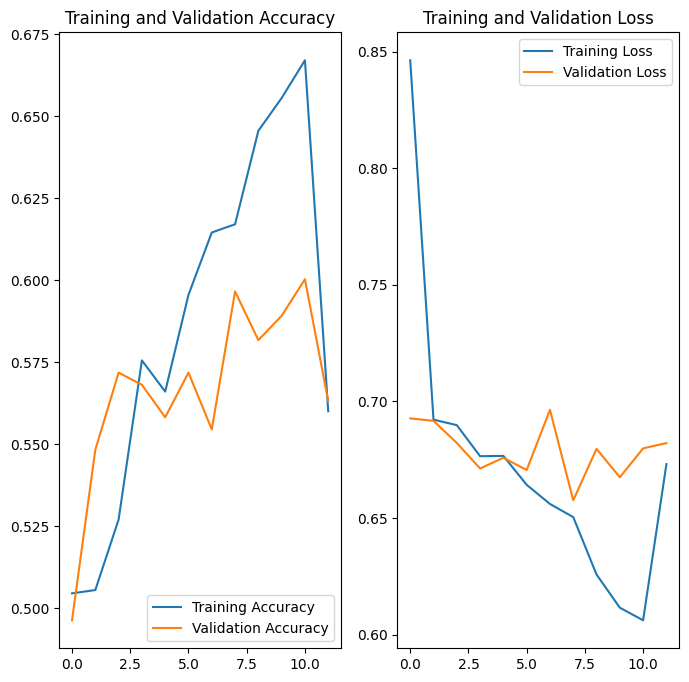

In [12]:
# Visualize the training history, including accuracy and loss over epochs.

# Extract training accuracy and validation accuracy from the training history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract training loss and validation loss from the training history.
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for plotting.
epochs_range = range(epochs)

# Set up a figure with two subplots for accuracy and loss visualization.
plt.figure(figsize=(8, 8))

# Subplot for accuracy.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot for loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots.
plt.show()




1. **Training and Validation Accuracy**:
   The left plot shows the model's accuracy during training (blue line) and validation (orange line) over different epochs.
   
   Initially, both training and validation accuracy increase. This indicates that the model is learning from the data.

   However,the training accuracy keeps increasing while the validation accuracy decreases, this suggest overfitting, where the model is memorizing the training data instead of generalizing well to new data.

2. **Training and Validation Loss**:
   The right plot displays the loss (a measure of error) during training (blue line) and validation (orange line) over epochs.
   
 At the start, both training and validation loss usually decrease, indicating improvement.
  The training loss keeps decreasing but validation loss starts increasing, this indicates overfitting. This means the model is fitting too closely to the training data and not performing well on new data.



### VGG-2 model

In [13]:
# Import necessary modules from Keras for building and training the model.
from keras.api._v2.keras import metrics
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers

# Define a model with 2 VGG blocks.
model = Sequential([
  # Rescale pixel values to be in the range [0, 1].
  layers.Rescaling(1./255, input_shape=(160, 160, 3)),

  # First Convolutional Block
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  # Second Convolutional Block
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  # Flatten for Fully Connected Layers
  layers.Flatten(),

  # Fully Connected Hidden Layer
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),

  # Output Layer
  layers.Dense(1, activation='sigmoid')
])

# Compile the model with stochastic gradient descent (SGD) optimizer.
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with 10 epochs.
epochs=10
history = model.fit(
  train_dataset,  # Use the training dataset for training.
  validation_data=validation_dataset,  # Use the validation dataset for validation.
  epochs=epochs  # Train for the specified number of epochs.
)


Epoch 1/10
63/63 [==============================] - 5s 59ms/step - loss: 0.7330 - accuracy: 0.5055 - val_loss: 0.6883 - val_accuracy: 0.5359
Epoch 2/10
63/63 [==============================] - 4s 54ms/step - loss: 0.6769 - accuracy: 0.5910 - val_loss: 0.6717 - val_accuracy: 0.5507
Epoch 3/10
63/63 [==============================] - 3s 49ms/step - loss: 0.6624 - accuracy: 0.5910 - val_loss: 0.6595 - val_accuracy: 0.6064
Epoch 4/10
63/63 [==============================] - 5s 73ms/step - loss: 0.6432 - accuracy: 0.6300 - val_loss: 0.6600 - val_accuracy: 0.5941
Epoch 5/10
63/63 [==============================] - 3s 49ms/step - loss: 0.6371 - accuracy: 0.6305 - val_loss: 0.6426 - val_accuracy: 0.6225
Epoch 6/10
63/63 [==============================] - 4s 53ms/step - loss: 0.6148 - accuracy: 0.6640 - val_loss: 0.6477 - val_accuracy: 0.5891
Epoch 7/10
63/63 [==============================] - 4s 59ms/step - loss: 0.6043 - accuracy: 0.6740 - val_loss: 0.6275 - val_accuracy: 0.6535
Epoch 8/10
63

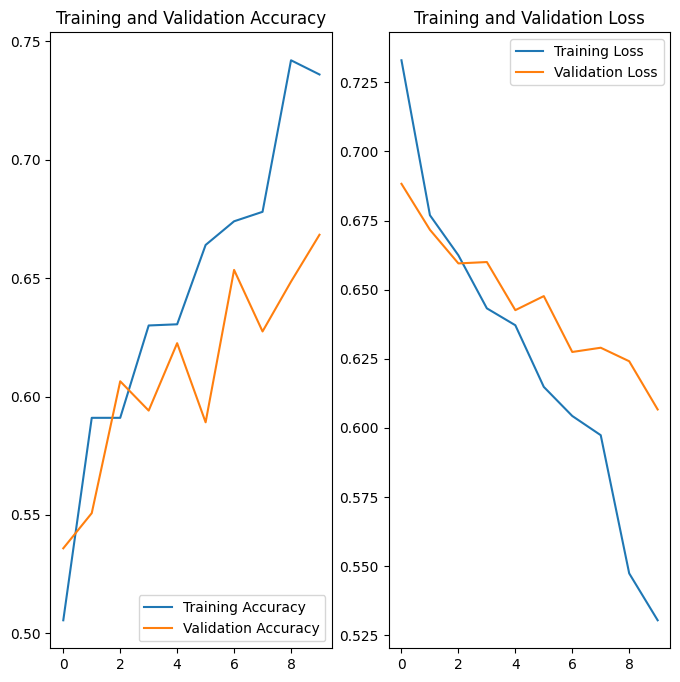

In [14]:
# Visualize the training history, including accuracy and loss over epochs.

# Extract training accuracy and validation accuracy from the training history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract training loss and validation loss from the training history.
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for plotting.
epochs_range = range(epochs)

# Set up a figure with two subplots for accuracy and loss visualization.
plt.figure(figsize=(8, 8))

# Subplot for accuracy.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot for loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots.
plt.show()




1. **Training and Validation Accuracy**:
   The left plot displays accuracy values on the y-axis and the number of epochs on the x-axis.
   The blue line represents the training accuracy, showing how well the model is performing on the training data as training progresses.
   The orange line represents the validation accuracy, indicating how well the model generalizes to new, unseen data.
   We can see that both lines show an increasing trend, it suggests the model is learning well. However, we can also see that the training accuracy significantly outperforms the validation accuracy, it is overfitting.

2. **Training and Validation Loss**:
   The right plot shows loss values on the y-axis and the number of epochs on the x-axis.
   Similar to accuracy, the blue line represents training loss (a measure of error), and the orange line represents validation loss.
   The goal is to minimize both training and validation loss.
   We can see that the training loss decreases but validation loss starts to increase,this may indicate overfitting, where the model is too closely fit to the training data.


### VGG-3 model

In [15]:
# Import necessary modules from Keras for building and training the model.
from keras.api._v2.keras import metrics
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers

# Define a model with 3 VGG blocks.
model = Sequential([
  # Rescale pixel values to be in the range [0, 1].
  layers.Rescaling(1./255, input_shape=(160, 160, 3)),

  # First Convolutional Block
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  # Second Convolutional Block
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  # Third Convolutional Block
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  # Flatten for Fully Connected Layers
  layers.Flatten(),

  # Fully Connected Hidden Layer
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),

  # Output Layer
  layers.Dense(1, activation='sigmoid')
])

# Compile the model with stochastic gradient descent (SGD) optimizer.
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with 10 epochs.
epochs=10
history = model.fit(
  train_dataset,  # Use the training dataset for training.
  validation_data=validation_dataset,  # Use the validation dataset for validation.
  epochs=epochs  # Train for the specified number of epochs.
)


Epoch 1/10
63/63 [==============================] - 5s 50ms/step - loss: 0.7449 - accuracy: 0.5230 - val_loss: 0.6773 - val_accuracy: 0.5433
Epoch 2/10
63/63 [==============================] - 3s 46ms/step - loss: 0.6685 - accuracy: 0.5885 - val_loss: 0.6532 - val_accuracy: 0.6547
Epoch 3/10
63/63 [==============================] - 4s 57ms/step - loss: 0.6462 - accuracy: 0.6235 - val_loss: 0.6906 - val_accuracy: 0.5408
Epoch 4/10
63/63 [==============================] - 3s 48ms/step - loss: 0.6271 - accuracy: 0.6605 - val_loss: 0.6319 - val_accuracy: 0.6411
Epoch 5/10
63/63 [==============================] - 3s 48ms/step - loss: 0.5950 - accuracy: 0.6920 - val_loss: 0.6078 - val_accuracy: 0.6782
Epoch 6/10
63/63 [==============================] - 4s 58ms/step - loss: 0.5835 - accuracy: 0.6990 - val_loss: 0.6386 - val_accuracy: 0.6287
Epoch 7/10
63/63 [==============================] - 4s 53ms/step - loss: 0.5668 - accuracy: 0.7110 - val_loss: 0.6028 - val_accuracy: 0.6535
Epoch 8/10
63

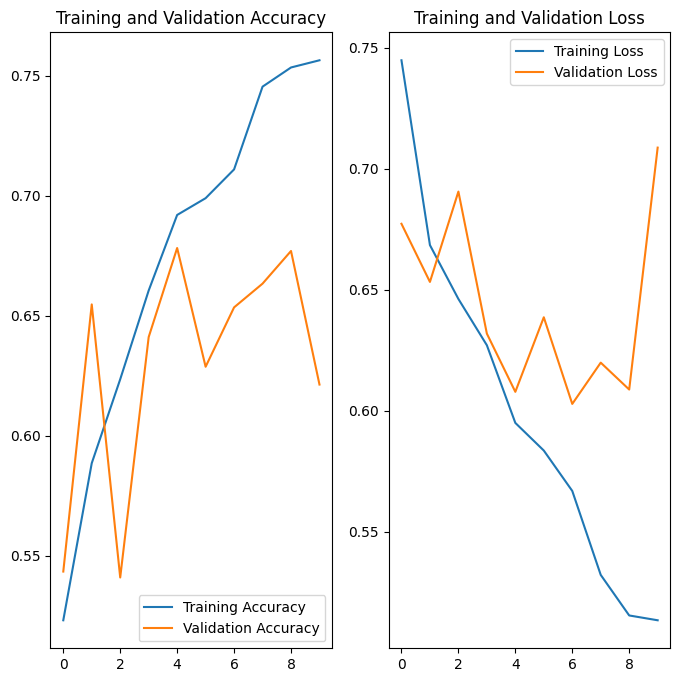

In [16]:
# Visualize the training history, including accuracy and loss over epochs.

# Extract training accuracy and validation accuracy from the training history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract training loss and validation loss from the training history.
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for plotting.
epochs_range = range(epochs)

# Set up a figure with two subplots for accuracy and loss visualization.
plt.figure(figsize=(8, 8))

# Subplot for accuracy.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot for loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots.
plt.show()



1. **Training and Validation Accuracy**:
  The left plot displays accuracy values on the y-axis and the number of epochs on the x-axis.
  The blue line represents the training accuracy, showing how well the model is performing on the training data as training progresses.
  The orange line represents the validation accuracy, indicating how well the model generalizes to new, unseen data.
  We can see that the both lines show an increasing trend, it suggests the model is learning well. However, we can also observe that the training accuracy significantly outperforms the validation accuracy, it is overfitting.

2. **Training and Validation Loss**:
   The right plot shows loss values on the y-axis and the number of epochs on the x-axis.
   Similar to accuracy, the blue line represents training loss (a measure of error), and the orange line represents validation loss.
   The goal is to minimize both training and validation loss.
   We can see that the training loss decreases but validation loss starts to increase, this indicates overfitting, where the model is too closely fit to the training data.


### Model improvements
 **Model improvements**: Refers to refining the architecture or parameters of a neural network to enhance its performance or efficiency.

**Data augmentation**: Technique of artificially increasing the size of a dataset by applying various transformations to existing data, aiding in better generalization and robustness of models.

**Dropouts**: A regularization technique that randomly sets a fraction of input units to zero during training, helping to prevent overfitting by reducing reliance on specific neurons.

In [18]:
# data augmentation
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

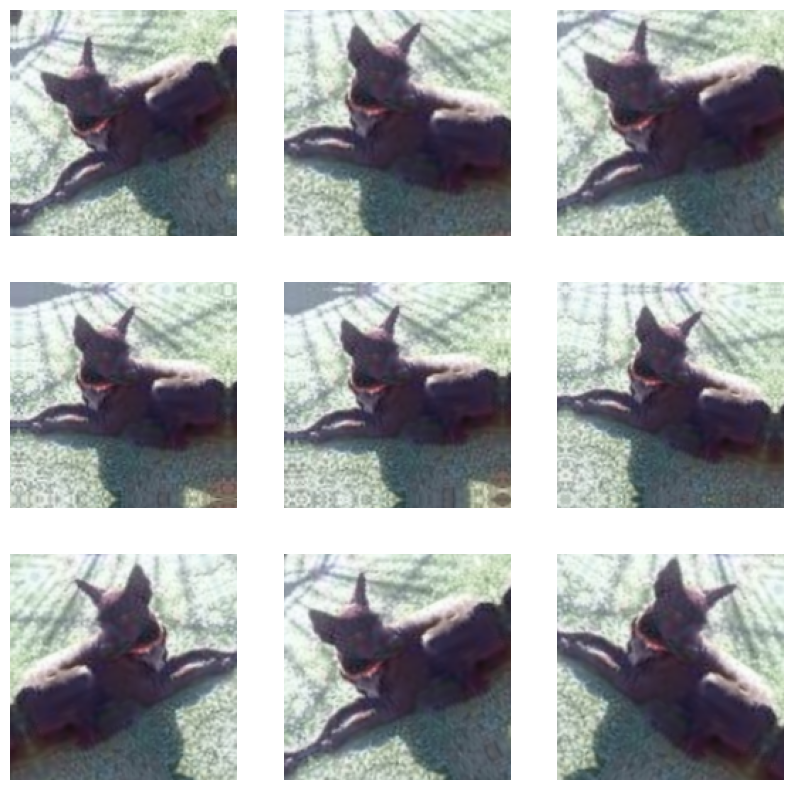

In [20]:
# Display augmented images for visualization.

# Set up a figure to display the augmented images.
plt.figure(figsize=(10, 10))

# Iterate through a batch of images from the training dataset.
for images, _ in train_dataset.take(1):
  # Iterate through a subset of the images (9 in this case).
  for i in range(9):
    # Apply data augmentation to the images.
    augmented_images = data_augmentation(images)

    # Set up a subplot to display the augmented image.
    ax = plt.subplot(3, 3, i + 1)

    # Display the augmented image.
    plt.imshow(augmented_images[0].numpy().astype("uint8"))

    # Turn off axis labels.
    plt.axis("off")


The grid provides a visual representation of how data augmentation affects the training data. It helps to ensure that the model is exposed to a wider range of variations, ultimately improving its ability to handle real-world data

In [21]:
# define a model with 1 VGG block
model = Sequential([
  data_augmentation,
  layers.Rescaling (1./255),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 80, 80, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 80, 80, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        9248      
                                                      

In [22]:
# train the model
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
63/63 [==============================] - 6s 58ms/step - loss: 0.8251 - accuracy: 0.5170 - val_loss: 0.6912 - val_accuracy: 0.5248
Epoch 2/10
63/63 [==============================] - 4s 63ms/step - loss: 0.6911 - accuracy: 0.5315 - val_loss: 0.6888 - val_accuracy: 0.5644
Epoch 3/10
63/63 [==============================] - 4s 65ms/step - loss: 0.6882 - accuracy: 0.5415 - val_loss: 0.6893 - val_accuracy: 0.5693
Epoch 4/10
63/63 [==============================] - 4s 61ms/step - loss: 0.6852 - accuracy: 0.5470 - val_loss: 0.6894 - val_accuracy: 0.5285
Epoch 5/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6881 - accuracy: 0.5400 - val_loss: 0.6902 - val_accuracy: 0.5087
Epoch 6/10
63/63 [==============================] - 5s 72ms/step - loss: 0.6865 - accuracy: 0.5455 - val_loss: 0.6883 - val_accuracy: 0.5545
Epoch 7/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6808 - accuracy: 0.5630 - val_loss: 0.6887 - val_accuracy: 0.5421
Epoch 8/10
63

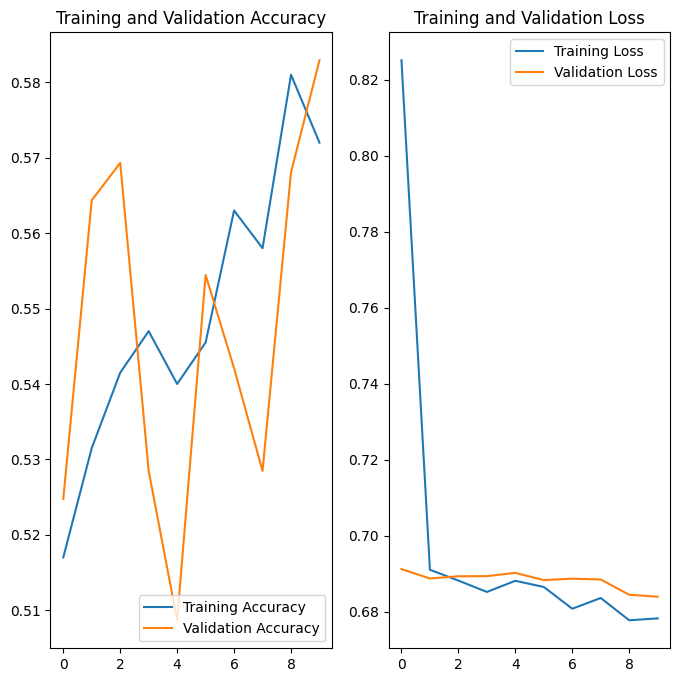

In [24]:
# Visualize the training history, including accuracy and loss over epochs.

# Extract training accuracy and validation accuracy from the training history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract training loss and validation loss from the training history.
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for plotting.
epochs_range = range(epochs)

# Set up a figure with two subplots for accuracy and loss visualization.
plt.figure(figsize=(8, 8))

# Subplot for accuracy.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot for loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots.
plt.show()




1. **Training and Validation Accuracy**:
   The left plot displays accuracy values on the y-axis and the number of epochs on the x-axis.
   The blue line represents the training accuracy, showing how well the model is performing on the training data as training progresses.
   The orange line represents the validation accuracy, indicating how well the model generalizes to new, unseen data.
   We can see that the both lines show an increasing trend, it suggests the model is learning well.

2. **Training and Validation Loss**:
   The right plot shows loss values on the y-axis and the number of epochs on the x-axis.
   Similar to accuracy, the blue line represents training loss (a measure of error), and the orange line represents validation loss.
   We can see that training loss decreases but validation loss starts to increase, this indicates overfitting, where the model is too closely fit to the training data.


## Transfer Learning with MobileNet V2
You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [25]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


#### Rescale pixel values
MobileNetV2 model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Note:** Alternatively, you could rescale pixel values from [0, 255] to [-1, 1] using tf.keras.layers.Rescaling.

  rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

**Note:** If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1, 1] or [0, 1], or use the included preprocess_input function.

### Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [27]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [28]:
# freeze the CNN base
base_model.trainable = False

In [29]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

### Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [31]:
# Create a Global Average Pooling layer.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Apply Global Average Pooling to the feature batch.
feature_batch_average = global_average_layer(feature_batch)

# Print the shape of the resulting feature batch after Global Average Pooling.
print(feature_batch_average.shape)


(32, 1280)


**Apply a tf.keras.layers.Dense layer** to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [32]:
# Create a Dense layer for making predictions.
prediction_layer = tf.keras.layers.Dense(1)

# Apply the Dense layer to the average-pooled features.
prediction_batch = prediction_layer(feature_batch_average)

# Print the shape of the resulting prediction batch.
print(prediction_batch.shape)


(32, 1)


**Build a model** by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [33]:
# Define the input shape for the model.
inputs = tf.keras.Input(shape=(160, 160, 3))

# Apply data augmentation to the input data.
x = data_augmentation(inputs)

# Preprocess the input data.
x = preprocess_input(x)

# Pass the preprocessed data through the base model (MobileNetV2) with training set to False (for inference).
x = base_model(x, training=False)

# Apply Global Average Pooling to reduce spatial dimensions.
x = global_average_layer(x)

# Apply a dropout layer with a dropout rate of 20%.
x = tf.keras.layers.Dropout(0.2)(x)

# Generate the final output predictions.
outputs = prediction_layer(x)

# Create the final model with defined inputs and outputs.
model = tf.keras.Model(inputs, outputs)

# Display a summary of the model architecture.
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

### Compile the model
Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [34]:
# Set the base learning rate for the optimizer.
base_learning_rate = 0.0001

# Compile the model with specified settings.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),  # Use the Adam optimizer with the specified learning rate.
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Define binary cross-entropy loss for binary classification task.
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')]  # Track binary accuracy as a metric during training.
)


### Train the model
After training for 10 epochs, you should see ~99% accuracy on the validation set.

In [36]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 1s 32ms/step - loss: 0.9956 - accuracy: 0.4963


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.90
initial accuracy: 0.52


Initial loss is 0.90, indicating a relatively high discrepancy between predictions and true labels. Initial accuracy is 0.52, signifying correct classification of 52% of samples, implying room for improvement.

In [37]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 69ms/step - loss: 0.7504 - accuracy: 0.5850 - val_loss: 0.5651 - val_accuracy: 0.7141
Epoch 2/10
63/63 [==============================] - 4s 55ms/step - loss: 0.5204 - accuracy: 0.7535 - val_loss: 0.3952 - val_accuracy: 0.8639
Epoch 3/10
63/63 [==============================] - 4s 54ms/step - loss: 0.4070 - accuracy: 0.8345 - val_loss: 0.3103 - val_accuracy: 0.9109
Epoch 4/10
63/63 [==============================] - 4s 64ms/step - loss: 0.3196 - accuracy: 0.8970 - val_loss: 0.2391 - val_accuracy: 0.9468
Epoch 5/10
63/63 [==============================] - 4s 54ms/step - loss: 0.2774 - accuracy: 0.9080 - val_loss: 0.2060 - val_accuracy: 0.9505
Epoch 6/10
63/63 [==============================] - 4s 55ms/step - loss: 0.2343 - accuracy: 0.9245 - val_loss: 0.1794 - val_accuracy: 0.9592
Epoch 7/10
63/63 [==============================] - 4s 64ms/step - loss: 0.2210 - accuracy: 0.9235 - val_loss: 0.1561 - val_accuracy: 0.9653
Epoch 8/10
63

### Learning curves
Now, let's examine the training and validation accuracy/loss curves using the MobileNetV2 base model as a static feature extractor.

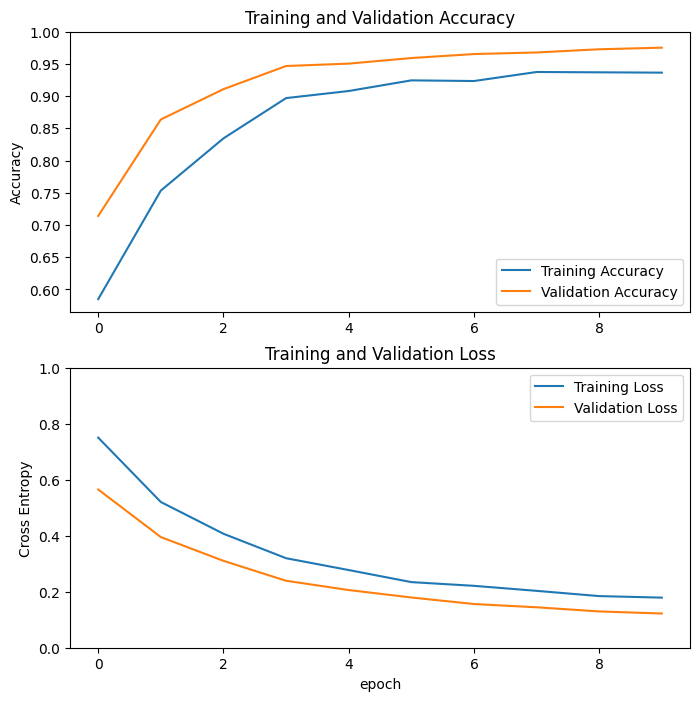

In [38]:
# Extract accuracy and loss values from training history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Set up a figure with two subplots for accuracy and loss visualization.
plt.figure(figsize=(8, 8))

# Subplot for accuracy.
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Subplot for loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

# Display the plots.
plt.show()


**Note:** The reason why validation metrics might appear superior to training metrics is primarily due to the influence of layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout. These layers affect accuracy during training but are inactive when computing validation loss. Additionally, to a minor degree, this difference arises from the fact that training metrics provide the average over an epoch, whereas validation metrics assess a model that has been trained slightly longer, as they are evaluated after the epoch.

### Fine tuning



In [39]:
# Set the base model to be trainable
base_model.trainable = True

# Output the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Define the point from which fine-tuning will occur
fine_tune_at = 100

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Compile the model with specific settings
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Binary cross-entropy loss for binary classification
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),  # Use RMSprop optimizer with adjusted learning rate
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')]  # Track binary accuracy as a metric
)

# Continue training with fine-tuning
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# Resume training with updated settings
history_fine = model.fit(
    train_dataset,  # Use the training dataset
    epochs=total_epochs,  # Train for the total number of epochs
    initial_epoch=history.epoch[-1],  # Start from the last epoch of the previous training
    validation_data=validation_dataset  # Use the validation dataset for evaluation
)


Number of layers in the base model:  154
Epoch 10/20
63/63 [==============================] - 15s 77ms/step - loss: 0.1157 - accuracy: 0.9520 - val_loss: 0.0424 - val_accuracy: 0.9901
Epoch 11/20
63/63 [==============================] - 5s 76ms/step - loss: 0.0893 - accuracy: 0.9680 - val_loss: 0.0470 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 4s 60ms/step - loss: 0.0769 - accuracy: 0.9720 - val_loss: 0.0365 - val_accuracy: 0.9864
Epoch 13/20
63/63 [==============================] - 4s 60ms/step - loss: 0.0702 - accuracy: 0.9755 - val_loss: 0.0399 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 5s 70ms/step - loss: 0.0609 - accuracy: 0.9760 - val_loss: 0.0375 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 4s 59ms/step - loss: 0.0525 - accuracy: 0.9795 - val_loss: 0.0341 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 5s 83ms/step - loss: 0.0536 - accuracy: 0.9800 - val_

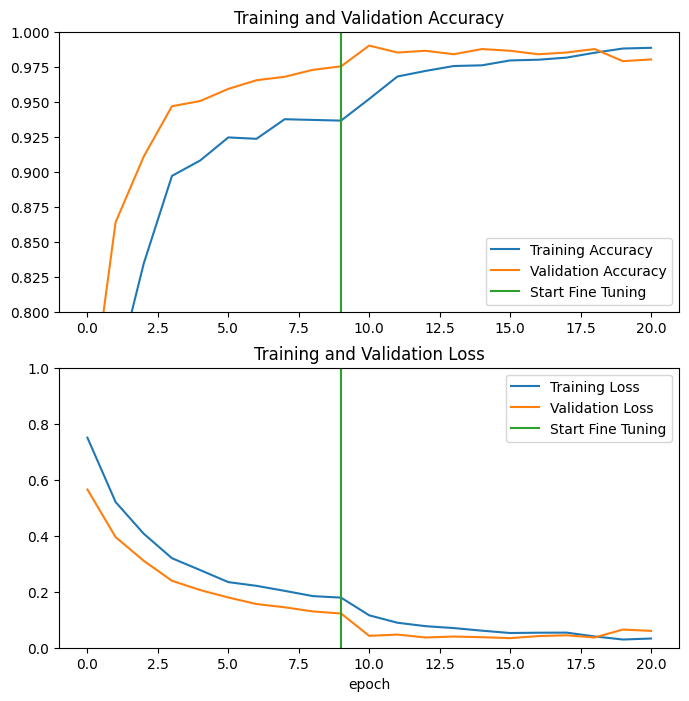

In [40]:
# Accumulate accuracy and loss values from fine-tuning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Set up a figure with two subplots for accuracy and loss visualization.
plt.figure(figsize=(8, 8))

# Subplot for accuracy.
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])  # Set y-axis limits for better visualization.
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')  # Vertical line indicating start of fine-tuning.
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot for loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])  # Set y-axis limits for better visualization.
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')  # Vertical line indicating start of fine-tuning.
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

# Display the plots.
plt.show()




1. **Training and Validation Accuracy**:
   The top plot displays the training and validation accuracy over epochs.
   The y-axis represents accuracy, ranging from 0.8 to 1.0 for better visualization.
   The vertical line indicates the point where fine-tuning began.

   **Interpretation**:
     The training accuracy steadily increases over epochs, indicating the model is learning from the data.
     The validation accuracy also improves, signifying that the model generalizes well to unseen data.
     Fine-tuning starts after the initial training phase.

2. **Training and Validation Loss**:
   The bottom plot illustrates the training and validation loss over epochs.
   The y-axis represents the loss, ranging from 0 to 1.0 for better visualization.
   The vertical line denotes the start of fine-tuning.

   **Interpretation**:

    The training loss steadily decreases, showing that the model is minimizing its error on the training data.
    The validation loss initially decreases, indicating good generalization. However, it starts to increase, suggesting potential overfitting.



### Evaluation and prediction
Ultimately, we can now assess the model's performance on fresh data by employing a test set.


6/6 [==============================] - 0s 34ms/step - loss: 0.0355 - accuracy: 0.9844
Test accuracy : 0.984375
Predictions:
 [0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0]
Labels:
 [0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0]


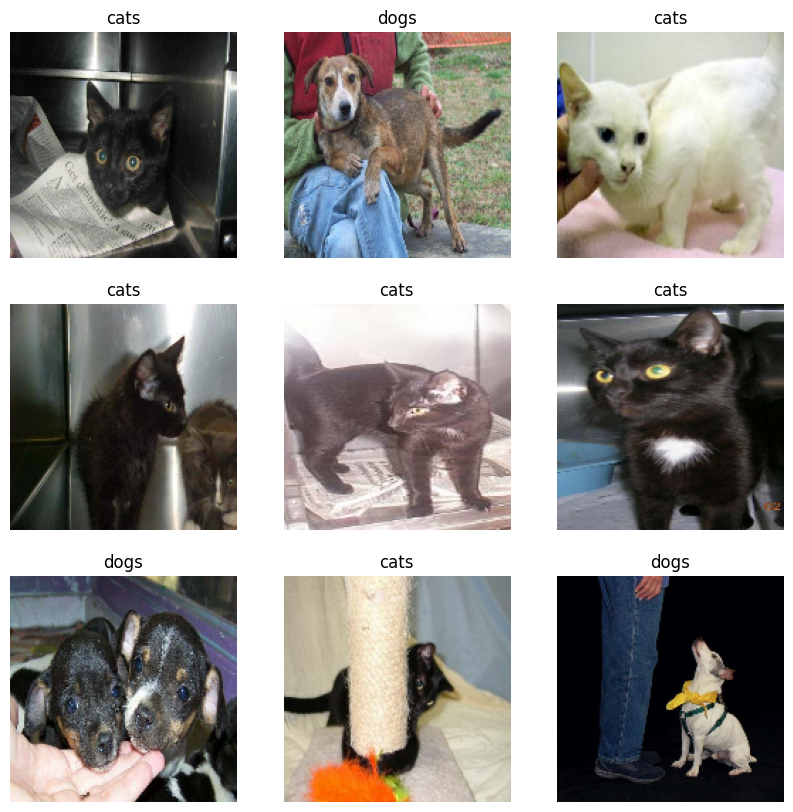

In [41]:
# Evaluate the model on the test dataset and retrieve loss and accuracy
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images and labels from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Make predictions on the batch of images
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid activation function since our model returns logits
predictions = tf.nn.sigmoid(predictions)

# Threshold the predictions to obtain binary class labels (0 or 1)
predictions = tf.where(predictions < 0.5, 0, 1)

# Print the predictions and true labels
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

# Display a 3x3 grid of images with predicted class labels
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


We can see that the output confirms that the model is performing very well on the test dataset, achieving a high accuracy of 98.44%. Additionally, it provides the specific predictions and true labels for a batch of test images, enabling a detailed assessment of the model's performance.